# MNIST: Training and Testing on a Clean Dataset & Adversarial Analysis

## Imports and MNIST loading

In [1]:
# For loading model sanely
import os.path

# Sys is used to add proper paths
import sys

import torch
import torch.nn as nn
from tqdm.notebook import tnrange, tqdm

# This here actually adds the path
sys.path.append("../")

import models.lenet as lenet

# For printing outcomes
import utils.printing as printing

In [2]:
# Define the `device` PyTorch will be running on, please hope it is CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Notebook will use PyTorch Device: " + device.upper())

Notebook will use PyTorch Device: CUDA


## Training, Validation and Testing

In [3]:
# Get the data loaders (assume we do no validation)
import utils.dataloaders as dataloaders

DATA_ROOT = "../datasets/"

trainSetLoader, _, testSetLoader = dataloaders.get_MNIST_data_loaders(
    DATA_ROOT,
    trainSetSize=50000,
    validationSetSize=0,
    batchSize=64,
)

In [4]:
# This method creates a new model and also trains it
def get_trained_model(load_if_available=False):
    # Helps speed up operations
    scaler = torch.cuda.amp.GradScaler()

    # Various training parameters
    epochs = 20
    learning_rate = 0.01

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = lenet.LeNet5().to(device)
    model.train()

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    # If a trained model already exists, give up the training part
    if load_if_available and os.path.isfile("../mnist_model"):
        print("Found already trained model")

        model = torch.load("../mnist_model")

        # Return the loaded model
        return model

    print("Training the model...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Training Progress"):
        # should_print_gradients = epoch == (epochs - 1)

        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)
            # images.requires_grad = True

            # Clean the gradients
            optimizer.zero_grad()

            # Predict
            logits = model(images)

            # Calculate loss
            with torch.cuda.amp.autocast():
                loss = loss_function(logits, labels)

            # Gradient descent
            scaler.scale(loss).backward()

            # Print image and gradient
            # if should_print_gradients:
            #     printing.print_gradient(images.grad[0])
            #     should_print_gradients = False
            scaler.step(optimizer)

            # Updates the scale for next iteration
            scaler.update()

    print("... done!")

    # Return the trained model
    return model

## Putting it all together (the 'main')

In [5]:
model = get_trained_model(load_if_available=True)

# From now on we simply test the model
model.eval()

# Test the loaded model
import utils.clean_test as clean_test

clean_test.test_trained_model(model, testSetLoader)

Found already trained model
Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.11%


In [6]:
# Save the model
torch.save(model, "../mnist_model")

## Attacks and Their Results

In [7]:
# A possible attacks array (for nice printing):
import utils.attacking as attacking

attacks = {}

### FGSM (Fast Sign Gradient Method) https://arxiv.org/abs/1412.6572

The formula that is used for producing the adversarial example in this case is:

$x' = x + \epsilon * sign(\nabla_{x}J(\theta, x, y))$, where J is the loss function used.

In [8]:
import attacks.fgsm as fgsm

attacks["FGSM"] = fgsm.fgsm_attack

In [9]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

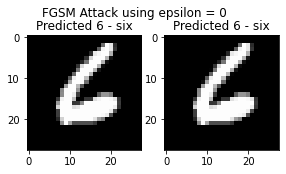

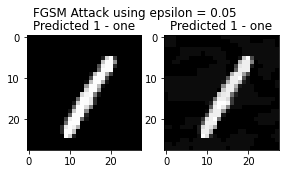

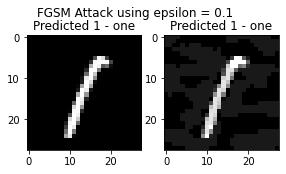

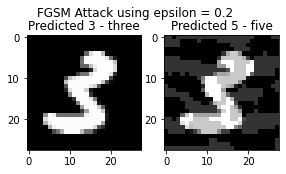

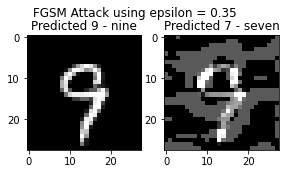

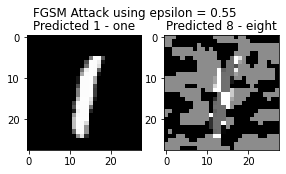

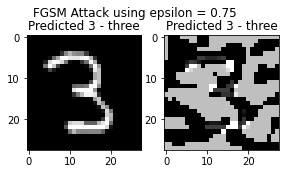

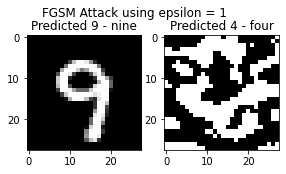

In [10]:
for epsilon in epsilons:
    printing.print_attack(
        model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

In [11]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.11%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 95.81%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 82.97%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 26.16%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 4.02%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 1.35%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 2.19%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 4.73%




### I-FGSM / BIM (Iterative FGSM / Basic Iterative Method) https://arxiv.org/abs/1607.02533

The formula that is used for producing the adversarial example in this case is:

$x'_{0} = x$
$x'_{k + 1} = Clip_{x, \epsilon} \{x'_{k} + \alpha * sign(\nabla_{x}J(\theta, x'_{k}, y)\}$, where J is the loss function used. Note that in the paper proposing this method, $\alpha = 1$ is used, so pixels are changed by 1 in each iteration.

The formula for the clip function is also given in the paper.

In [12]:
import attacks.ifgsm as ifgsm

attacks["I-FGSM"] = ifgsm.ifgsm_attack

In [13]:
# Several values for epsilon. It's interesting to see how clamping affects results
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55]

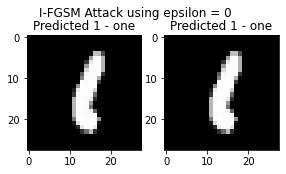

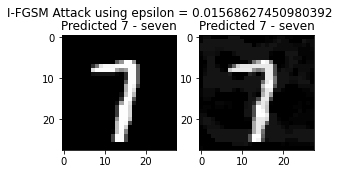

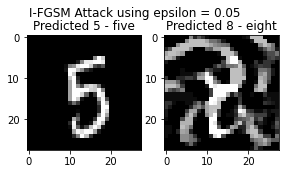

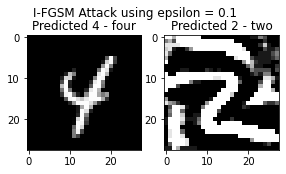

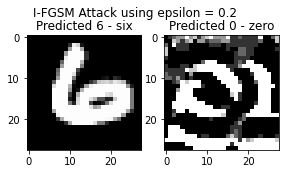

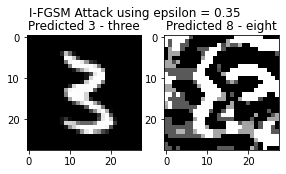

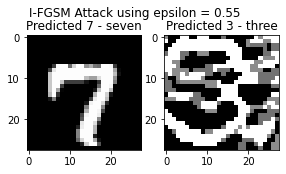

In [14]:
for epsilon in epsilons:
    printing.print_attack(
        model,
        testSetLoader,
        "I-FGSM",
        attacks["I-FGSM"],
        epsilon=epsilon,
        alpha=1,
        iterations=0,
    )

In [54]:
for epsilon in epsilons:
    attacking.attack_model(
        model,
        testSetLoader,
        "I-FGSM",
        attacks["I-FGSM"],
        epsilon=epsilon,
        alpha=1,
        iterations=3,
    )

Testing the model under I-FGSM Attack using epsilon = 0, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.11%


Testing the model under I-FGSM Attack using epsilon = 0.01568627450980392, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 95.85%


Testing the model under I-FGSM Attack using epsilon = 0.05, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 39.57%


Testing the model under I-FGSM Attack using epsilon = 0.1, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.36%


Testing the model under I-FGSM Attack using epsilon = 0.2, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 0.35, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 0.55, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 0.75, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under I-FGSM Attack using epsilon = 1, alpha = 1...


I-FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.04%




### PGD (Projected Gradient Descent) https://arxiv.org/pdf/1706.06083.pdf

The formula that is used for producing the adversarial example in this case is:

$x^{t+1} = \Pi_{x+S}(x^t+\alpha sgn(\bigtriangledown_x L(\theta, x, y)))$\n
where S is a set of allowed perturbations. Note that this is basically BIM with random initialisation. 

We use the $L_{\infty}$ norm here, i.e. we use clamping. 

In [16]:
import attacks.pgd as pgd

In [17]:
attacks["PGD"] = pgd.pgd_attack

In [18]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

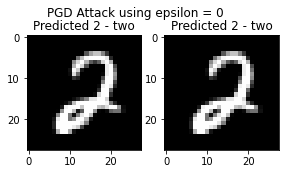

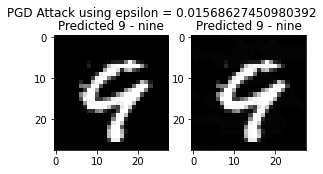

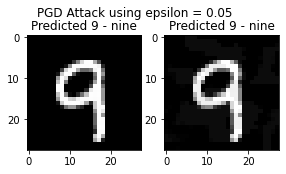

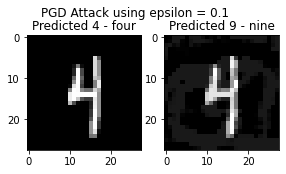

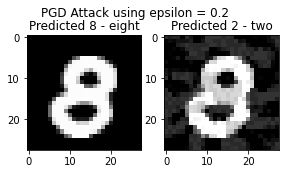

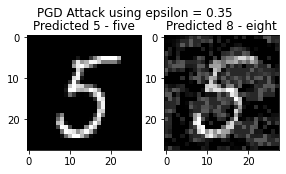

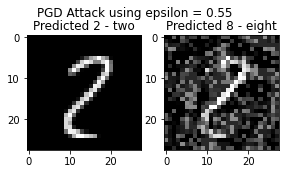

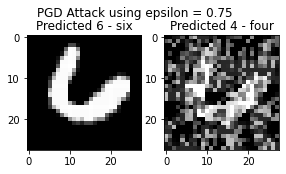

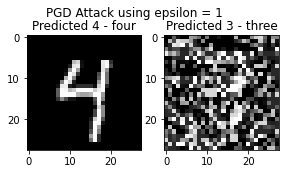

In [19]:
for epsilon in epsilons:
    printing.print_attack(
        model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=20,
    )

In [20]:
for epsilon in epsilons:
    attacking.attack_model(
        model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=20,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.11%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.47%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 95.14%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 75.99%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 22.72%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 5.03%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.23%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.0%




## From here, use existing libraries to simplify usageimport torchattacks


In [21]:
import torchattacks

### DeepFool https://arxiv.org/pdf/1511.04599.pdf

The formula here is complex, so I recommend for the interested reader to go the above link to read the full paper.

In [68]:
deepfool_attack = torchattacks.DeepFool(model)

attacks["DeepFool"] = deepfool_attack

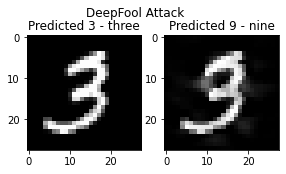

In [69]:
printing.print_attack(
    model, testSetLoader, "DeepFool", attacks["DeepFool"], library=True
)

In [70]:
attacking.attack_model(
    model,
    testSetLoader,
    "DeepFool",
    attacks["DeepFool"],
    library=True,
)

Testing the model under DeepFool Attack...


DeepFool Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 0.41%




### CW-$L_{2}$ (Carlini & Wagner using $L_{2}$ norm) https://arxiv.org/pdf/1608.04644.pdf

The formula here is complex, so I recommend for the interested reader to go the above link to read the full paper.

In [59]:
cw_attack = torchattacks.CW(model, c=20)

attacks["CW"] = cw_attack

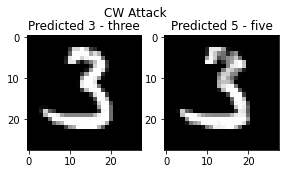

In [60]:
printing.print_attack(model, testSetLoader, "CW", attacks["CW"], library=True)

In [61]:
attacking.attack_model(
    model,
    testSetLoader,
    "CW",
    attacks["CW"],
    library=True,
)

Testing the model under CW Attack...


CW Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 3.65%




## Adversarial Training

In [25]:
# Adversarial examples should be typically generated when model parameters are not
# changing i.e. model parameters are frozen. This step may not be required for very
# simple linear models, but is a must for models using components such as dropout
# or batch normalization.
def get_adversarially_trained_model(attack, **kwargs):
    # Various training parameters
    epochs = 20
    learning_rate = 0.01

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = lenet.LeNet5().to(device)
    model.train()

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    # Check if using epsilon
    if "epsilon" in kwargs:
        epsilon = kwargs["epsilon"]
    else:
        epsilon = None

    # Check if using alpha
    if "alpha" in kwargs:
        alpha = kwargs["alpha"]
    else:
        alpha = None

    # Get iterations
    if "iterations" in kwargs:
        iterations = kwargs["iterations"]
    else:
        iterations = None

    # Get the attack
    attack_function = attacks[attack]

    print("Training the model using adversarial examples...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Adversarial Training Progress"):
        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            # Run the attack
            model.eval()
            perturbed_images = attack_function(
                images,
                labels,
                model,
                loss_function,
                epsilon=epsilon,
                alpha=alpha,
                scale=True,
                iterations=iterations,
            )
            model.train()

            # Predict and optimise
            optimizer.zero_grad()

            logits = model(perturbed_images)
            loss = loss_function(logits, labels)

            # Gradient descent
            loss.backward()

            optimizer.step()

    print("... done!")

    # Return the trained model
    return model

### FGSM Adversarial Training

In [26]:
fgsm_model = get_adversarially_trained_model("FGSM", epsilon=0.2)

clean_test.test_trained_model(fgsm_model, testSetLoader)

Training the model using adversarial examples...


Adversarial Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

... done!
Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.49%


In [27]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [28]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        fgsm_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.49%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.31%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.12%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 97.56%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 74.87%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 20.61%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 13.47%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 12.85%




In [29]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [30]:
for epsilon in epsilons:
    attacking.attack_model(
        fgsm_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.49%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 97.87%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 94.95%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 90.58%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 78.9%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 52.89%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 17.29%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 5.54%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 2.91%




In [31]:
clean_test.test_trained_model(fgsm_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.49%


### PGD Adversarial Training

In [32]:
pgd_model = get_adversarially_trained_model(
    "PGD", epsilon=0.6, alpha=(2 / 255), iterations=7
)

Training the model using adversarial examples...


Adversarial Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

... done!


In [33]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [34]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        pgd_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.08%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.04%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 96.05%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 85.94%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 48.24%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 12.83%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 12.42%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 17.65%




In [35]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [36]:
for epsilon in epsilons:
    attacking.attack_model(
        pgd_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.08%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.81%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.17%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 97.94%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 97.63%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 97.33%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 96.72%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 89.3%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 22.62%




In [37]:
clean_test.test_trained_model(pgd_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.08%


## Interpolated Adversarial Training

In [38]:
import defenses.iat as iat


def get_interpolated_adversarially_trained_model(attack, **kwargs):
    # Various training parameters
    epochs = 20
    learning_rate = 0.01

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = lenet.LeNet5().to(device)
    model.train()

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    # Check if using epsilon
    if "epsilon" in kwargs:
        epsilon = kwargs["epsilon"]
    else:
        epsilon = None

    # Check if using alpha
    if "alpha" in kwargs:
        alpha = kwargs["alpha"]
    else:
        alpha = None

    # Get iterations
    if "iterations" in kwargs:
        iterations = kwargs["iterations"]
    else:
        iterations = None

    # Get the attack
    attack_function = attacks[attack]

    print("Training the model using adversarial examples...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Adversarial Training Progress"):
        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            # Make sure previous step gradients are not used
            optimizer.zero_grad()

            # Use manifold mixup to modify the data
            (
                benign_mix_images,
                benign_mix_labels_a,
                benign_mix_labels_b,
                benign_mix_lamda,
            ) = iat.mix_inputs(1, images, labels)

            # Predict and calculate benign loss
            benign_logits = model(benign_mix_images)
            benign_loss = iat.mixup_loss_function(
                loss_function,
                benign_mix_lamda,
                benign_logits,
                benign_mix_labels_a,
                benign_mix_labels_b,
            )

            # Run the adversarial attack
            model.eval()
            perturbed_images = attack_function(
                images,
                labels,
                model,
                loss_function,
                epsilon=epsilon,
                alpha=alpha,
                scale=True,
                iterations=iterations,
            )
            model.train()

            # Use manifold mixup on the adversarial data
            (
                adversarial_mix_images,
                adversarial_mix_labels_a,
                adversarial_mix_labels_b,
                adversarial_mix_lamda,
            ) = iat.mix_inputs(1, perturbed_images, labels)

            # Predict and calculate adversarial loss
            adversarial_logits = model(adversarial_mix_images)
            adversarial_loss = iat.mixup_loss_function(
                loss_function,
                adversarial_mix_lamda,
                adversarial_logits,
                adversarial_mix_labels_a,
                adversarial_mix_labels_b,
            )

            # Take average of the two losses
            loss = (benign_loss + adversarial_loss) / 2

            # Gradient descent
            loss.backward()
            optimizer.step()

    print("... done!")

    # Return the trained model
    return model

In [39]:
iat_pgd_model = get_interpolated_adversarially_trained_model(
    "PGD", epsilon=0.6, alpha=(2 / 255), iterations=7
)

Training the model using adversarial examples...


Adversarial Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

... done!


In [40]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [41]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        iat_pgd_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.23%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 96.64%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 89.88%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 63.37%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 30.09%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 20.59%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 12.82%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 5.5%




In [42]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [43]:
for epsilon in epsilons:
    attacking.attack_model(
        iat_pgd_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.23%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.6%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 96.14%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 94.63%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 96.27%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 96.9%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 95.96%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 86.9%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 15.51%




In [44]:
clean_test.test_trained_model(iat_pgd_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.23%


## Adversarial Logit Pairing (https://arxiv.org/pdf/1803.06373.pdf)

In [45]:
def get_alp_trained_model(attack, **kwargs):
    # Various training parameters
    epochs = 20
    learning_rate = 0.01

    # ALP factor
    alp_loss_function = nn.MSELoss()
    alp_lamda = 0.2

    # Network parameters
    loss_function = nn.CrossEntropyLoss()
    model = lenet.LeNet5().to(device)
    model.train()

    # Consider using ADAM here as another gradient descent algorithm
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
    )

    # Check if using epsilon
    if "epsilon" in kwargs:
        epsilon = kwargs["epsilon"]
    else:
        epsilon = None

    # Check if using alpha
    if "alpha" in kwargs:
        alpha = kwargs["alpha"]
    else:
        alpha = None

    # Get iterations
    if "iterations" in kwargs:
        iterations = kwargs["iterations"]
    else:
        iterations = None

    # Get the attack
    attack_function = attacks[attack]

    print("Training the model using adversarial examples...")

    # Use a pretty progress bar to show updates
    for epoch in tnrange(epochs, desc="Adversarial Training Progress"):
        for _, (images, labels) in enumerate(tqdm(trainSetLoader, desc="Batches")):
            # Cast to proper tensors
            images, labels = images.to(device), labels.to(device)

            # Run the attack
            model.eval()
            perturbed_images = attack_function(
                images,
                labels,
                model,
                loss_function,
                epsilon=epsilon,
                alpha=alpha,
                scale=True,
                iterations=iterations,
            )
            model.train()

            # Predict and optimise
            optimizer.zero_grad()

            logits = model(images)
            loss = loss_function(logits, labels) + alp_lamda * alp_loss_function(
                model(images), model(perturbed_images)
            )

            # Gradient descent
            loss.backward()

            optimizer.step()

    print("... done!")

    # Return the trained model
    return model

In [46]:
alp_model = get_alp_trained_model("PGD", epsilon=0.6, alpha=(2 / 255), iterations=7)

Training the model using adversarial examples...


Adversarial Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

... done!


In [47]:
# Several values to use for the epsilons
epsilons = [0, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [48]:
# Run test for each epsilon
for epsilon in epsilons:
    attacking.attack_model(
        alp_model,
        testSetLoader,
        "FGSM",
        attacks["FGSM"],
        epsilon=epsilon,
    )

Testing the model under FGSM Attack using epsilon = 0, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.18%


Testing the model under FGSM Attack using epsilon = 0.05, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.0%


Testing the model under FGSM Attack using epsilon = 0.1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 95.9%


Testing the model under FGSM Attack using epsilon = 0.2, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 87.1%


Testing the model under FGSM Attack using epsilon = 0.35, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 54.35%


Testing the model under FGSM Attack using epsilon = 0.55, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 12.52%


Testing the model under FGSM Attack using epsilon = 0.75, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 5.43%


Testing the model under FGSM Attack using epsilon = 1, alpha = None...


FGSM Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 7.34%




In [49]:
# Several values to use for the epsilons
epsilons = [0, 4 / 255, 0.05, 0.1, 0.2, 0.35, 0.55, 0.75, 1]

In [50]:
for epsilon in epsilons:
    attacking.attack_model(
        alp_model,
        testSetLoader,
        "PGD",
        attacks["PGD"],
        epsilon=epsilon,
        alpha=(2 / 255),
        iterations=7,
    )

Testing the model under PGD Attack using epsilon = 0, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.18%


Testing the model under PGD Attack using epsilon = 0.01568627450980392, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.84%


Testing the model under PGD Attack using epsilon = 0.05, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 98.19%


Testing the model under PGD Attack using epsilon = 0.1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 97.78%


Testing the model under PGD Attack using epsilon = 0.2, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 97.38%


Testing the model under PGD Attack using epsilon = 0.35, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 96.75%


Testing the model under PGD Attack using epsilon = 0.55, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 95.27%


Testing the model under PGD Attack using epsilon = 0.75, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 89.67%


Testing the model under PGD Attack using epsilon = 1, alpha = 0.00784313725490196...


PGD Attack Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 52.4%




In [51]:
clean_test.test_trained_model(alp_model, testSetLoader)

Testing the model...


Testing Progress:   0%|          | 0/157 [00:00<?, ?it/s]

... done! Accuracy: 99.18%
